In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from DDPG.dpsolver import DPSolver
from DDPG.agent import Agent
from DDPG.utils import configObj
from DDPG.models import QNetwork, PolicyNetwork
from DDPG.envs import CakeEatEnv
from DDPG.utils import LR_SCHEME

In [2]:
config_name = 'DDPG/config'
cfg = configObj(config_name,verbose=False)
env = CakeEatEnv(cfg)
OPTIMAL_ACTION = env.c_star(1)
lr_scheme = LR_SCHEME(cfg)

In [3]:
def best_actor(s):
    a = torch.tensor([OPTIMAL_ACTION], requires_grad=True)
    return a*s

def plot(ax, model, label):
    s = torch.linspace(cfg.ENV_STATE_SPACE_L, cfg.ENV_STATE_SPACE_H, 100).unsqueeze(-1)
    a = best_actor
    with torch.no_grad():
        v = model(s, a(s))
    s = s.squeeze(-1).detach().numpy()
    v = v.squeeze(-1).detach().numpy()
    ax.plot(s, v, label=label);
    ax.legend(fontsize=20);

In [4]:
dp = DPSolver(cfg)
dp.solve(best_actor)


Converged in 373 iterations.


Epoch 0: lr 0.0100, train loss 475.271515

Epoch 1000: lr 0.0043, train loss 82.725800

Epoch 2000: lr 0.0022, train loss 142.545547

Epoch 3000: lr 0.0014, train loss 10.059719

Epoch 4000: lr 0.0012, train loss 1.095936

Epoch 5000: lr 0.0011, train loss 253.101074

Epoch 6000: lr 0.0010, train loss 13.792203

Epoch 7000: lr 0.0010, train loss 9.150260

Epoch 8000: lr 0.0010, train loss 7.643929

Epoch 9000: lr 0.0010, train loss 21.190468



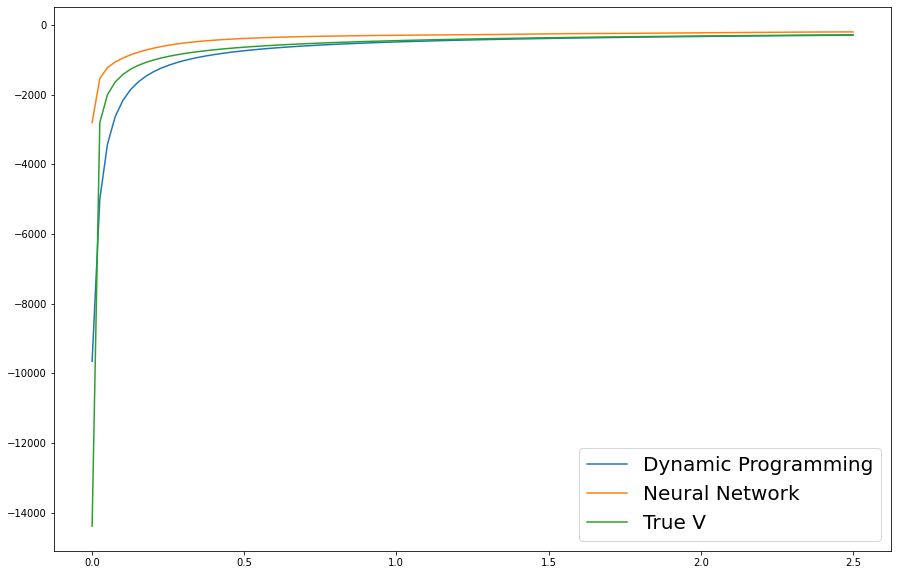

In [5]:
critic = QNetwork(state_dim=env.observation_space.shape[0],
                  action_dim=env.action_space.shape[0],
                  hidden_dim=cfg.CRITIC_HIDDEN_DIM,
                  num_hidden_layer=cfg.CRITIC_NUM_HIDDEN_LAYER,
                  activate=cfg.CRITIC_ACTIVATE,
                  batch_norm=cfg.CRITIC_BATCH_NORM,
                  weight_init=cfg.CRITIC_WEIGHT_INIT)

actor = best_actor

critic_optim = optim.Adam(critic.parameters(), lr=cfg.MAX_CRITIC_LR)
actor_optim = _

agent = Agent(env=env, critic=critic, actor=actor, critic_optim=critic_optim, actor_optim=actor_optim)

for i in range(10000):
    s = env.gen_states(sampling=True, B=100)
    a = agent.actor(s)
    r, s_ = env.transit(s, a)
    a_ = agent.actor(s_)
    data = [s, a, r, s_, a_, cfg.ENV_TRANSITION_NUM_STEPS]
    train_q_loss= agent.update_critic(data, lr_scheme(i)[0])
    if i % cfg.REPORT_PER_ITERATION == 0:
        print(f"Epoch {i}: lr {lr_scheme(i)[0]:.4f}, train loss {train_q_loss:.6f}\n")
        
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot(ax, dp, label='Dynamic Programming')
plot(ax, agent.critic, label='Neural Network')
s = np.linspace(cfg.ENV_STATE_SPACE_L, cfg.ENV_STATE_SPACE_H, 100)
ax.plot(s, env.v_star(s), label='True V')
ax.legend(fontsize=20);

Epoch 0:
 lr 0.0100, train q loss 14.1403,  train policy loss 0.0599
         test q loss 2484418.2500, test policy loss 0.2507


Epoch 1000:
 lr 0.0043, train q loss 0.3605,  train policy loss 128.3086
         test q loss 2281331.0000, test policy loss 0.2782


Epoch 2000:
 lr 0.0022, train q loss 1.0779,  train policy loss 130.8989
         test q loss 2277845.2500, test policy loss 0.2737


Epoch 3000:
 lr 0.0014, train q loss 0.5711,  train policy loss 129.9562
         test q loss 2277928.2500, test policy loss 0.2719


Epoch 4000:
 lr 0.0012, train q loss 0.8115,  train policy loss 119.7993
         test q loss 2287031.7500, test policy loss 0.2854


Epoch 5000:
 lr 0.0011, train q loss 1.7463,  train policy loss 141.0521
         test q loss 2242325.5000, test policy loss 0.2847


Epoch 6000:
 lr 0.0010, train q loss 0.9491,  train policy loss 128.0518
         test q loss 2260534.5000, test policy loss 0.2764


Epoch 7000:
 lr 0.0010, train q loss 0.3987,  train policy loss 12

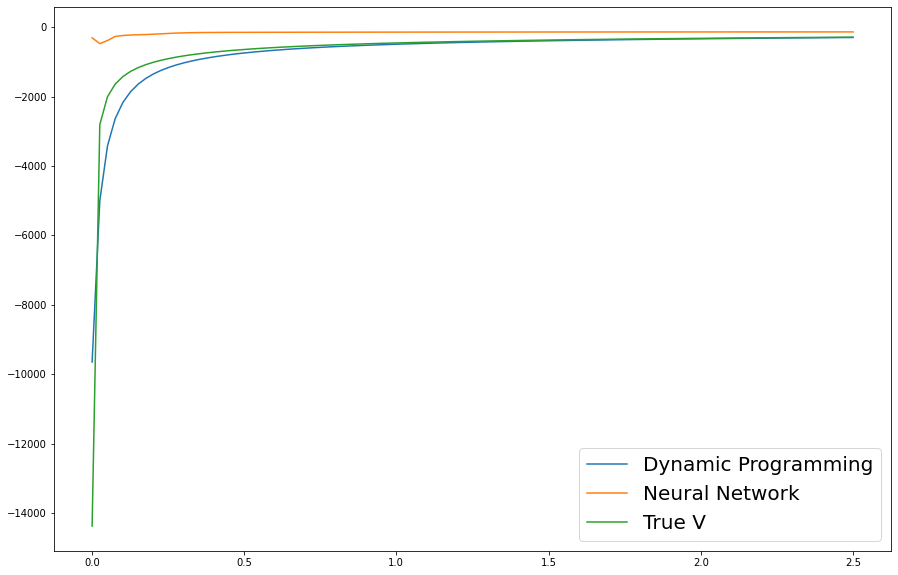

In [6]:
critic = QNetwork(state_dim=env.observation_space.shape[0],
                  action_dim=env.action_space.shape[0],
                  hidden_dim=cfg.CRITIC_HIDDEN_DIM,
                  num_hidden_layer=cfg.CRITIC_NUM_HIDDEN_LAYER,
                  activate=cfg.CRITIC_ACTIVATE,
                  batch_norm=cfg.CRITIC_BATCH_NORM,
                  weight_init=cfg.CRITIC_WEIGHT_INIT)

actor = PolicyNetwork(state_dim=env.observation_space.shape[0],
                  action_dim=env.action_space.shape[0],
                  hidden_dim=cfg.ACTOR_HIDDEN_DIM,
                  num_hidden_layer=cfg.ACTOR_NUM_HIDDEN_LAYER,
                  activate=cfg.ACTOR_ACTIVATE,
                  batch_norm=cfg.ACTOR_BATCH_NORM,
                  weight_init=cfg.ACTOR_WEIGHT_INIT)

critic_optim = optim.Adam(critic.parameters(), lr=cfg.MAX_CRITIC_LR)
actor_optim = optim.Adam(actor.parameters(), lr=cfg.MAX_ACTOR_LR)

agent = Agent(env=env, critic=critic, actor=actor, critic_optim=critic_optim, actor_optim=actor_optim)

for i in range(20000):
    s = env.gen_states(sampling=True, B=32)
    a = agent.actor(s)
    r, s_ = env.transit(s, a)
    a_ = agent.actor(s_)
    data = [s, a, r, s_, a_, cfg.ENV_TRANSITION_NUM_STEPS]
    train_q_loss= agent.update_critic(data, lr_scheme(i)[0])
    train_policy_loss = agent.update_actor(s, lr_scheme(i)[1])
    test_q_loss = agent.test_critic()
    test_policy_loss = agent.test_actor()
    if i % cfg.REPORT_PER_ITERATION == 0:
        print(f"Epoch {i}:\n lr {lr_scheme(i)[0]:.4f}, train q loss {train_q_loss:.4f},  train policy loss {train_policy_loss:.4f}\n \
        test q loss {test_q_loss:.4f}, test policy loss {test_policy_loss:.4f}\n\n")
        
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot(ax, dp, label='Dynamic Programming')
plot(ax, agent.critic, label='Neural Network')
s = np.linspace(cfg.ENV_STATE_SPACE_L, cfg.ENV_STATE_SPACE_H, 100)
ax.plot(s, env.v_star(s), label='True V')
ax.legend(fontsize=20);

In [ ]:
critic = QNetwork(state_dim=env.observation_space.shape[0],
                  action_dim=env.action_space.shape[0],
                  hidden_dim=cfg.CRITIC_HIDDEN_DIM,
                  num_hidden_layer=cfg.CRITIC_NUM_HIDDEN_LAYER,
                  activate=cfg.CRITIC_ACTIVATE,
                  batch_norm=cfg.CRITIC_BATCH_NORM,
                  weight_init=cfg.CRITIC_WEIGHT_INIT)

actor = PolicyNetwork(state_dim=env.observation_space.shape[0],
                  action_dim=env.action_space.shape[0],
                  hidden_dim=cfg.ACTOR_HIDDEN_DIM,
                  num_hidden_layer=cfg.ACTOR_NUM_HIDDEN_LAYER,
                  activate=cfg.ACTOR_ACTIVATE,
                  batch_norm=cfg.ACTOR_BATCH_NORM,
                  weight_init=cfg.ACTOR_WEIGHT_INIT)

critic_optim = optim.Adam(critic.parameters(), lr=cfg.MAX_CRITIC_LR)
actor_optim = optim.Adam(actor.parameters(), lr=cfg.MAX_ACTOR_LR)

agent = Agent(env=env, critic=critic, actor=actor, critic_optim=critic_optim, actor_optim=actor_optim)

for i in range(10000):
    s = env.gen_states(sampling=False, B=100)
    a = agent.actor(s)
    r, s_ = env.transit(s, a)
    a_ = agent.actor(s_)
    data = [s, a, r, s_, a_, cfg.ENV_TRANSITION_NUM_STEPS]
    train_q_loss= agent.update_critic(data, lr_scheme(i)[0])
    train_policy_loss = 0
    if i % cfg.REPORT_PER_ITERATION == 0:
        print(f"Epoch {i}: lr {lr_scheme(i)[0]:.4f}, q loss {train_q_loss:.6f},  policy loss {train_policy_loss:.6f}\n")
        
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot(ax, dp, label='Dynamic Programming')
plot(ax, agent.critic, label='Neural Network')
s = np.linspace(cfg.ENV_STATE_SPACE_L, cfg.ENV_STATE_SPACE_H, 100)
ax.plot(s, env.v_star(s), label='True V')
ax.legend(fontsize=20);

Epoch 0: lr 0.0100, q loss 12.175509,  policy loss 0.000000

Epoch 1000: lr 0.0043, q loss 0.064997,  policy loss 0.000000

Epoch 2000: lr 0.0022, q loss 0.103486,  policy loss 0.000000

